#**HURRICANE CHAOS GAME**

PART III
```
Miriam Nohemi López Cruz
Vrije Universiteit Brussel, Belgium
Email: miriam.nohemi.lopez.cruz@vub.be
```

In this notebook, we will obtain the activations from the intermediate layers of a pre-trained network (VGG-16) on the ImageNet dataset, when passing the images of the Hurricane Chaos game.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
path = '/content/drive/MyDrive/'

In [ ]:
# Import the required packages and PyTorch libraries
from PIL import Image
import os
import glob
import shutil
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

plt.ion()   # interactive mode

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torchvision
from torchvision import datasets, models, transforms


In [ ]:
# Load the dataset with clutter-metrics evaluated images.
hc = pd.read_csv(path+'hurricane_game.csv')

In [ ]:
# Target folder where images will be sorted into themes
#!mkdir  /content/drive/MyDrive/target_dataset
source_folder = path+'hurricanescenes/'
target_folder = path+'target_dataset'

## Initialize hyperparameters

In [ ]:
batch_size = 4
num_epochs = 25
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

## Load the dataset

Target data: Hurricane Chaos game dataset, divided into train and val folder, each divided by the respective 5 themes.
The source data in this task is the Imagenet dataset and the target data will be Hurricane Chaos game images dataset.

We will load the dataset from the local directory and then use the Pytorch <code>dataset.ImageFolder</code> API to preprocess and passed the images to the <code>torch.utils.data.DataLoader</code>. The dataloader API can load multiple samples in parallel using <code>torch.multiprocessing</code> workers.

In [ ]:
transforms = transforms.Compose([transforms.RandomResizedCrop(224),
                                 transforms.RandomHorizontalFlip(),
                                 transforms.ToTensor(),
                                 transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])

data_dir = target_folder
train_set = datasets.ImageFolder(os.path.join(data_dir, 'train'), transforms)
val_set = datasets.ImageFolder(os.path.join(data_dir, 'val'), transforms)

train_loader = torch.utils.data.DataLoader(train_set, batch_size=4, shuffle=True, num_workers=4)
val_loader = torch.utils.data.DataLoader(val_set, batch_size=4, shuffle=True, num_workers=4)

train_size = len(train_set)
val_size = len(val_set)

classes = train_set.classes

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [ ]:
print(train_size)
print(val_size)

5868
1402


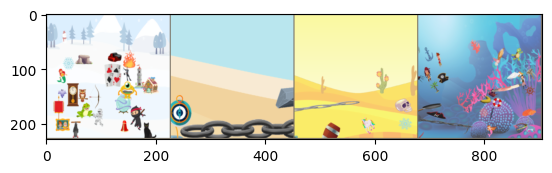

FantasyOldKids Pirates FantasyOldKids Pirates


In [ ]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
images, labels = next(iter(train_loader))

imshow(torchvision.utils.make_grid(images))
print(' '.join('%5s' % classes[labels[j]] for j in range(batch_size)))

In [ ]:
model_ft = models.vgg16(weights='DEFAULT')
model_ft = model_ft.to(device)

In [ ]:
#print(model_ft)

In [ ]:
model_ft.features[23]

MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)

In [ ]:
#Function to find all MaxPool layers within the VGG-16 network

def get_all_maxpool_layers(model):
    conv_layers = []
    counter = 0
    for name, module in model.named_modules():
        if isinstance(module, nn.MaxPool2d):
            conv_layers.append(module)
            counter += 1
    return conv_layers, counter

conv_layers, counter = get_all_maxpool_layers(model_ft)
print(conv_layers)
print(f"Num. of MaxPool layers:{counter}")

[MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False), MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False), MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False), MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False), MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)]
Num. of MaxPool layers:5


### **Register a forward hook**

We need to register a forward hook to the desired layers (max-pooling layer in this case) to capture the activations during the forward pass.

In [ ]:
activation = {}  # Dictionary to store activations

def get_activation(name):
    def hook(model, input, output):
        activation[name] = output.detach()
    return hook

# Find the 4th MaxPool2d layer in model_ft.features and register the hook
for name, module in model_ft.named_modules():
    if isinstance(module, nn.MaxPool2d):  # Check for MaxPool2d layers
        module.register_forward_hook(get_activation(name))
        #break  # Register hook to the first MaxPool2d layer and break


## Visualization of Feature Maps


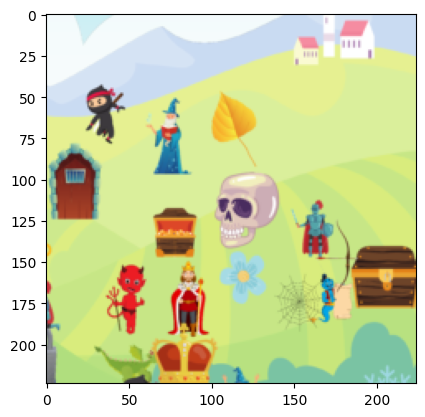

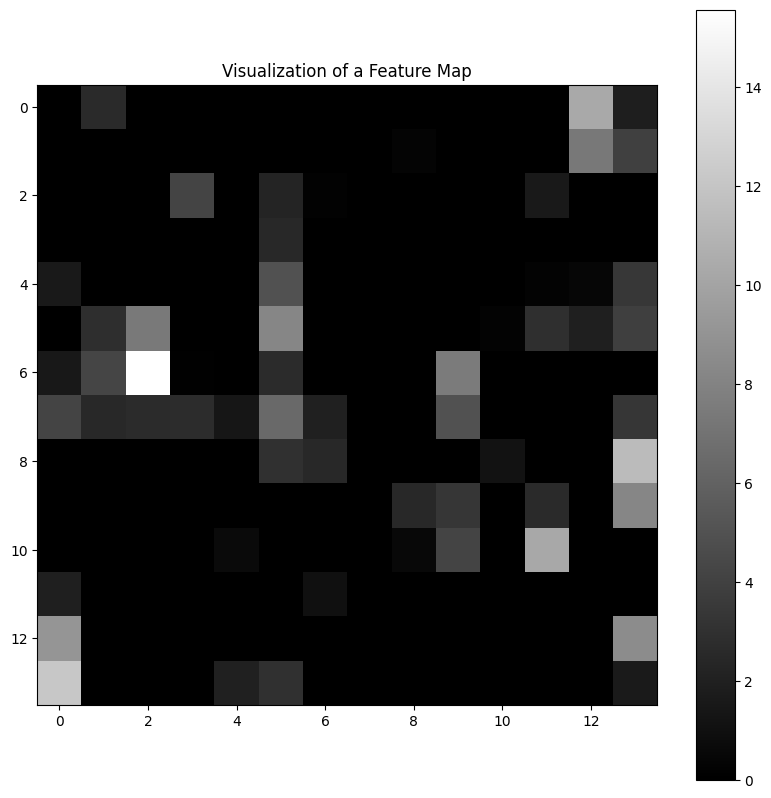

In [ ]:
images, _ = next(iter(train_loader))
test_image = images[0,:,:,:].unsqueeze(0).to(device) # Move test_image to the device
imshow(images[0,:,:,:])

# Obtain the activation for the test image
with torch.no_grad():
    model_ft(test_image)  # Pass the test image through the model
activation_energy_maxpool1 = activation['features.4'] #Activation Energy of the 1st MaxPool layer
activation_energy_maxpool3 = activation['features.16'] #Activation Energy of the 3rd MaxPool layer
activation_energy_maxpool4 = activation['features.23'] #Activation Energy of the 4th MaxPool layer

# For visualization purposes, we select the second feature map (or channel) of the fourth MaxPool layer
feature_map_to_visualize = activation_energy_maxpool4[0, 1, :, :]

# Visualize the selected feature map
plt.figure(figsize=(10, 10))
plt.imshow(feature_map_to_visualize.cpu(), cmap='gray') # Using a suitable colormap for feature visualization
plt.colorbar() # Adding a colorbar to interpret the values
plt.title('Visualization of a Feature Map')
plt.show()


In [ ]:
print(activation.keys())
print(activation['features.23'])
print(activation['features.23'].shape)

dict_keys(['features.4', 'features.9', 'features.16', 'features.23', 'features.30'])
tensor([[[[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
          [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
          [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
          ...,
          [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
          [ 8.3526,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
          [ 7.1865,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]],

         [[ 0.0000,  2.5858,  0.0000,  ...,  0.0000, 10.3264,  1.8328],
          [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  7.3366,  3.8985],
          [ 0.0000,  0.0000,  0.0000,  ...,  1.5295,  0.0000,  0.0000],
          ...,
          [ 1.9172,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
          [ 9.0971,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  8.5307],
          [12.1274,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  1.5909]],

         [[ 5.509

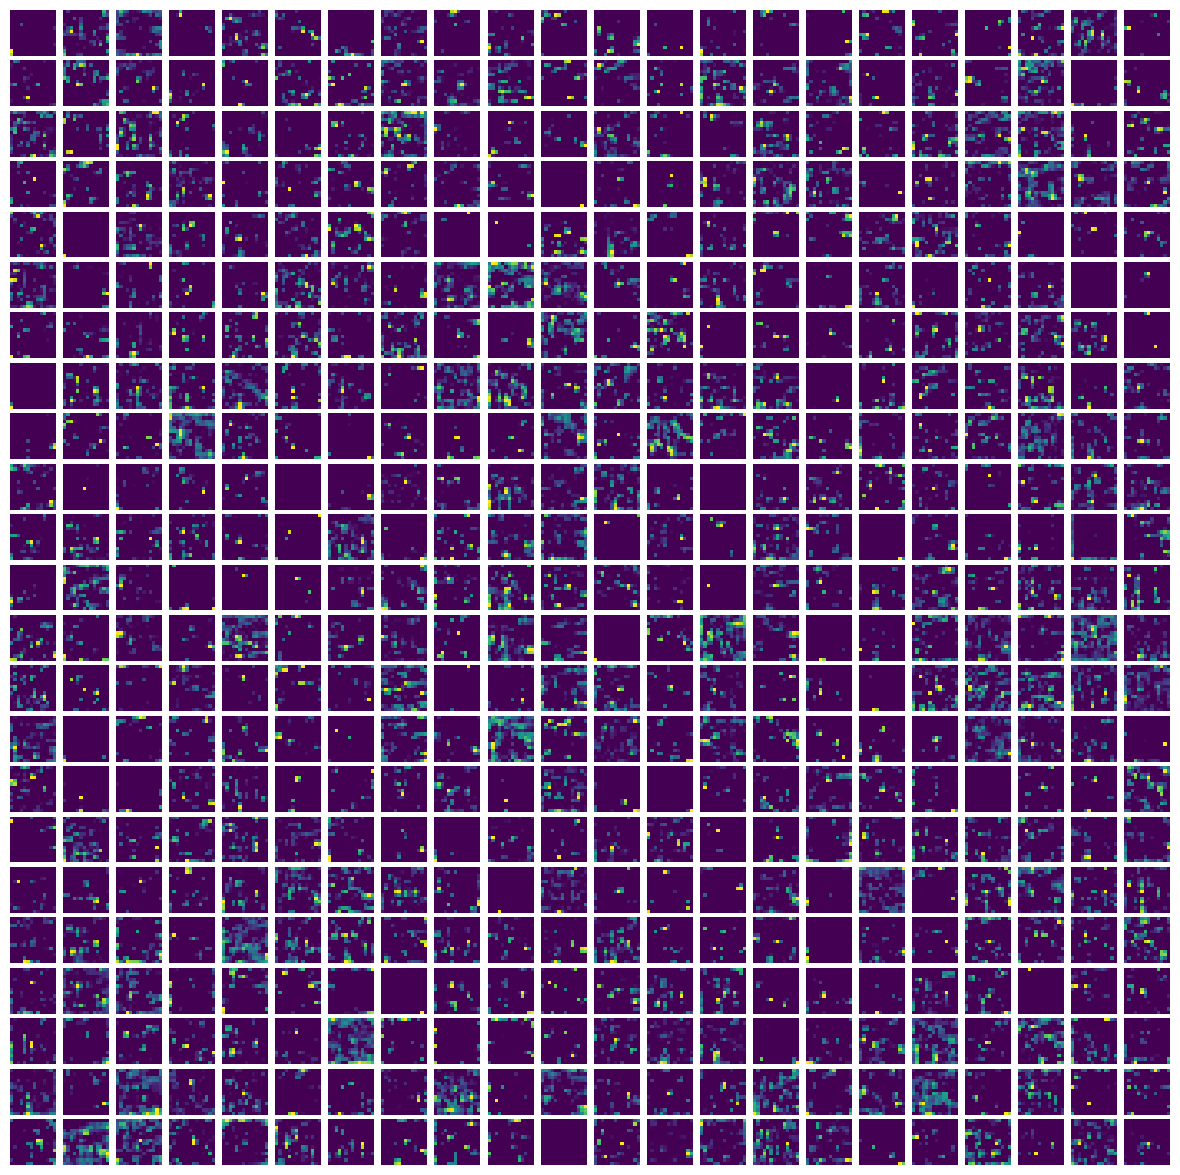

In [ ]:
# Visualize all the feature maps of the 4th MaxPool layer
num_maps = activation_energy_maxpool4.size(1)  # We select the number of channels

# Create a grid of subplots
num_cols = int(num_maps**0.5)
num_rows = num_cols + (num_maps % num_cols > 0)
fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 15))
fig.subplots_adjust(hspace=0.1, wspace=0.1)
axes = axes.flatten()

# Plot each feature map
for i, feature_map in enumerate(activation_energy_maxpool4[0]):
  if i < len(axes):  # Ensure enough subplots
    axes[i].imshow(feature_map.cpu(), cmap='viridis')
    axes[i].axis('off')

plt.show()  # Display the grid

## Visualization of Energy Maps

torch.Size([1, 28, 28])


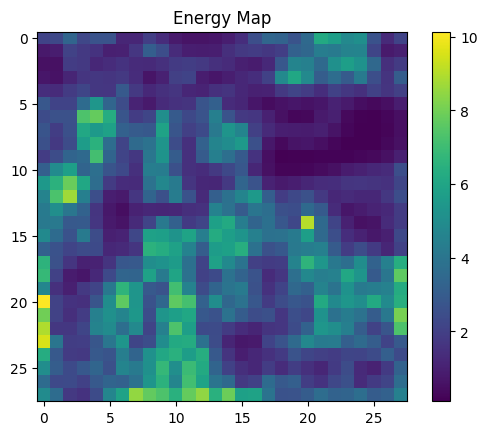

In [ ]:
# Average over the channels:
energy_map_maxpool3 = torch.mean(activation_energy_maxpool3, dim=1)  # Average across dimension 1 (channels)
print(energy_map_maxpool3.shape)
#energy_map_maxpool1 = torch.mean(activation_energy_maxpool1, dim=1)  # Average across dimension 1 (channels)

# Visualize with matplotlib:
plt.imshow(energy_map_maxpool3[0].cpu().numpy(), cmap='viridis')  # Visualize the first image in the batch
plt.colorbar()  # Add a colorbar to show the energy scale
plt.title('Energy Map')
plt.show()

# **Unsupervised Activation Energy**

In [ ]:
# Example of unsupervised activation energy using the 3rdMaxPool layer

# Calculate the average across all dimensions:
unsupervised_activation_energy = torch.mean(activation_energy_maxpool3)

# Print or use the unsupervised activation energy
print(f"Unsupervised Activation Energy: {unsupervised_activation_energy}")

Unsupervised Activation Energy: 2.937537908554077


**Obtain UAE and AE of each image**  

In [ ]:
train_loader_dataset = []  # Initialize an empty list to store all filenames, mean activations and mean activation accross channels

def get_activation(name):
    def hook(model, input, output):
        activation[name] = output.detach()
    return hook

# Find the 4th MaxPool2d layer in model_ft.features and register the hook
for name, module in model_ft.named_modules():
    if isinstance(module, nn.MaxPool2d):  # Check for MaxPool layers
        module.register_forward_hook(get_activation(name))

# Process images in batches
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_ft = model_ft.to(device)  # Ensure model is on the correct device
model_ft.eval()  # Set the model to evaluation mode

# Iterate through all batches in the train_loader
for batch_idx, (images, labels) in enumerate(train_loader):
    # Iterate through each image in the current batch
    for i in range(images.size(0)):
        activation = {}  # Dictionary to store activations
        # Extract the filename using the index in train_set.samples
        img_file = train_set.samples[batch_idx * train_loader.batch_size + i][0][-11:]
        # Access the individual image tensor from the batch
        input_image = images[i].unsqueeze(0).to(device)
        with torch.no_grad():
          model_ft(input_image)  # Pass the test image through the model
        activation_energy_pool3 = activation['features.16']
        activation_energy_pool4 = activation['features.23']
        #feature_map_weights = activation_energy_pool4.cpu().squeeze().numpy()  # Remove batch dimension
        unsupervised_activation_energy3 = torch.mean(activation_energy_pool3)
        unsupervised_activation_energy4 = torch.mean(activation_energy_pool4)
        energy_map = torch.mean(activation_energy_pool3, dim=1)
        # Append the filename and flattened weights to the dataset
        train_loader_dataset.append({
          "filename": img_file,
          "uae_maxpool3": float(unsupervised_activation_energy3.cpu()),
          "uae_maxpool4": float(unsupervised_activation_energy4.cpu()),
          "energy_map_maxpool3": energy_map.cpu().squeeze().numpy().flatten().tolist()
          })

In [ ]:
val_loader_dataset = []

# Iterate through all batches in the val_loader
for batch_idx, (images, labels) in enumerate(val_loader):
    # Iterate through each image in the current batch
    for i in range(images.size(0)):
        activation = {}  # Dictionary to store activations
        # Extract the filename using the index in train_set.samples
        img_file = val_set.samples[batch_idx * val_loader.batch_size + i][0][-11:]
        # Access the individual image tensor from the batch
        input_image = images[i].unsqueeze(0).to(device)
        with torch.no_grad():
          model_ft(input_image)  # Pass the test image through the model
        activation_energy_pool3 = activation['features.16']
        activation_energy_pool4 = activation['features.23']
        #feature_map_weights = activation_energy_pool4.cpu().squeeze().numpy()  # Remove batch dimension
        unsupervised_activation_energy3 = torch.mean(activation_energy_pool3)
        unsupervised_activation_energy4 = torch.mean(activation_energy_pool4)
        energy_map = torch.mean(activation_energy_pool3, dim=1)
        # Append the filename and flattened weights to the dataset
        val_loader_dataset.append({
          "filename": img_file,
          "uae_maxpool3": float(unsupervised_activation_energy3.cpu()),
          "uae_maxpool4": float(unsupervised_activation_energy4.cpu()),
          "energy_map_maxpool3": energy_map.cpu().squeeze().numpy().flatten().tolist()
          })

In [ ]:
print(train_loader_dataset[0])
print(val_loader_dataset[0])

{'filename': '1004846.png', 'uae_maxpool3': 3.345154285430908, 'uae_maxpool4': 1.3214699029922485, 'energy_map_maxpool3': [3.9606847763061523, 3.2747883796691895, 2.5861096382141113, 1.819973349571228, 1.568937063217163, 1.295194149017334, 1.7096192836761475, 1.0950195789337158, 0.8395743370056152, 0.8185750246047974, 1.1871132850646973, 2.977261781692505, 4.61488676071167, 4.451944828033447, 4.717952728271484, 7.397963523864746, 6.682476997375488, 3.3470420837402344, 1.7619200944900513, 1.7875950336456299, 2.356882095336914, 4.554497718811035, 4.823757171630859, 3.6795706748962402, 3.8589038848876953, 4.051210403442383, 3.398298740386963, 3.8834166526794434, 3.0695581436157227, 4.343914031982422, 9.044868469238281, 4.296728134155273, 2.179499626159668, 1.5847530364990234, 1.224816083908081, 0.5063927173614502, 0.26830580830574036, 0.2257135808467865, 0.38865500688552856, 1.079986572265625, 1.4387297630310059, 3.5414981842041016, 2.335501194000244, 2.355067253112793, 4.716795921325684,

In [ ]:
print(len(train_loader_dataset))
print(len(train_loader_dataset[0]['energy_map_maxpool3']))
print(len(val_loader_dataset))
print(len(val_loader_dataset[0]['energy_map_maxpool3']))

5868
784
1402
784


In [ ]:
# Convert the new datasets to DataFrames
df_train = pd.DataFrame(train_loader_dataset)
df_val = pd.DataFrame(val_loader_dataset)

In [ ]:
# Concatenate dataframes
concat_df_simplenet = pd.concat([df_train, df_val], ignore_index=True)

# Adjust filename column to same format as the other datasets
concat_df_simplenet["filename"] = concat_df_simplenet["filename"].str.strip("/")
concat_df_simplenet["filename"] = concat_df_simplenet["filename"].str.strip(".png")
concat_df_simplenet["id"] = concat_df_simplenet["filename"].astype(int)

print(concat_df_simplenet.shape)
print(concat_df_simplenet['filename'].nunique())

(7270, 5)


In [ ]:
print(concat_df_simplenet['filename'].nunique())

7270


In [ ]:
concat_df_simplenet.head()

,filename,uae_maxpool3,uae_maxpool4,energy_map_maxpool3,id
0,1004846,3.345154,1.321470,"[3.9606847763061523, 3.2747883796691895, 2.586...",1004846
1,1005332,2.762568,1.238151,"[4.248599052429199, 3.095947027206421, 2.45430...",1005332
2,1009126,1.769485,0.863113,"[1.4576084613800049, 0.7602958083152771, 0.664...",1009126
3,1010665,1.492527,0.719724,"[5.2825775146484375, 2.8845326900482178, 4.348...",1010665
4,1011552,2.268690,0.900165,"[2.5959768295288086, 1.197830080986023, 0.7947...",1011552


In [ ]:
# Convert to csv file
#pd.DataFrame.to_csv(concat_df_simplenet,"/content/drive/MyDrive/df_simplenet.csv", index=False)

In [ ]:
#I tried using the images directly from the images folder but this method is only taking 2444 samples

from torchvision import transforms
from PIL import Image


transforms = transforms.Compose([transforms.RandomResizedCrop(224),
                                 transforms.RandomHorizontalFlip(),
                                 transforms.ToTensor(),
                                 transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])

dataset_img = []
activation = {}  # Dictionary to store activations


def get_activation(name):
    def hook(model, input, output):
        activation[name] = output.detach()
    return hook

# Find the 4th MaxPool2d layer in model_ft.features and register the hook
for name, module in model_ft.named_modules():
    if isinstance(module, nn.MaxPool2d):  # Check for MaxPool2d layers
        module.register_forward_hook(get_activation(name))
        #break  # Register hook to the first MaxPool2d layer and break

# Process images in batches
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_ft = model_ft.to(device)  # Ensure model is on the correct device
model_ft.eval()  # Set the model to evaluation mode

img_folder_path = source_folder

# Use os.walk to iterate through all files in subdirectories
for root, _, files in os.walk(img_folder_path):
  print (str(root), str(files))
  for file in files:
    img_path = os.path.join(root,file) # Get the full path to the image file
    img_file = str(file)
    try:
      image = Image.open(img_path).convert('RGB')
      # Apply transformations
      input_image = transforms(image).unsqueeze(0).to(device)
      # Forward pass
      with torch.no_grad():
        model_ft(input_image)
      activation_energy_pool3 = activation['features.16']
      activation_energy_pool4 = activation['features.23']
      unsupervised_activation_energy3 = torch.mean(activation_energy_pool3)
      unsupervised_activation_energy4 = torch.mean(activation_energy_pool4)
      energy_map = torch.mean(activation_energy_pool3, dim=1)

      # Append the filename and flattened weights to the dataset
      dataset_img.append({
        "filename": img_file,
        "uae_maxpool3": float(unsupervised_activation_energy3.cpu()),
        "uae_maxpool4": float(unsupervised_activation_energy4.cpu()),
        "energy_map_maxpool3": energy_map.cpu().squeeze().numpy().flatten().tolist()
      })
    except (IOError, ValueError) as e:
        print(f"Error processing image {img_path}: {e}")

# Convert the dataset to a DataFrame
#df_img = pd.DataFrame(dataset_img)

#TEST IMAGE !
#/content/drive/MyDrive/hurricanescenes/533581.png

#img_path = os.path.join(path, 'hurricanescenes/', img_str)